# Introduction 
The [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset consits of 60,000 color images of size 32 x 32 collected by by Krizhevsky, Nair, and Hinton. The dataset has 10 classes, each class having 6,000 images which is divided in to two groups: 
* Training: 50,000 images 
* Testing: 10,000 images 


The classes are completely mutually exclusive. There is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks.

In the following, you will apply different algorithms to the task of object recognition in the images of the aforementioned dataset. Above each cell is a text file with a task for you to complete. If you do not own a laptop with a capable GPU, you can use [google colab](https://colab.research.google.com). Click File -> Upload Notebook to upload your exercise. Then on the right side of the screen you will find Connect -> View Resources -> Change Runtime Type. Here you should have three options to choose from: None, GPU, and TPU. Select GPU as your runtime type. Note that in the non-Pro version, you can only use GPU for a limited time. However, the exercise was performed with the free version without any problems or issues, so you do not need to upgrade to the Pro version to complete the exercise.   



Importing required packages

In [1]:
import os

from collections import Counter

import numpy as np

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics

import tensorflow as tf
from tensorflow.keras import Input, Model, layers, losses, callbacks, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

* Load the data, rescale it and split the **original training** data into training (10000 samples), validation (1000 samples ) and test set (1000 samples)
* Print the shape of your training set
* Print the number of samples in each class
* Compute the mean and standard deviation of your training and test set

In [28]:
from re import X
# Code for loading the data
from tensorflow.keras.datasets import cifar10
(xtrain_, ytrain), (xtest, ytest) = cifar10.load_data()

# Classes (are given)
classes = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])

# Code for splitting the data into train/val/test set 
Xtrain_, Xrest_, Ytrain, Yrest_ = train_test_split(xtrain_, ytrain, train_size=10000)
Xval_, Xrest_, Yval, Yrest_ = train_test_split(Xrest_, Yrest_, train_size=1000)
Xtest_, Xrest_, Ytest, Yrest_ = train_test_split(Xrest_, Yrest_, train_size=1000)

# Code for rescaling the images
def preprocess_images(x) :
  return x.astype('float32')/255

Xtrain = preprocess_images(Xtrain_)
Xval = preprocess_images(Xval_)
Xtest = preprocess_images(Xtest_)

# Code for printing the shape of your training set 
print(Xtrain.shape)


# Code for printing the # of samples in each class 
Ytrain = Ytrain.flatten()
Yval = Yval.flatten()
Ytest = Ytest.flatten()

print("train :", Counter(Ytrain))
print("val :", Counter(Yval))
print("test :", Counter(Ytest))

# Code for computing the mean and std of the training and test set
(train_mean, train_std) = (np.mean(Xtrain, axis=0), np.std(Xtrain, axis=0))
(test_mean, test_std) = (np.mean(Xtest, axis=0), np.std(Xtest, axis=0))

(10000, 32, 32, 3)
train : Counter({4: 1031, 2: 1021, 9: 1016, 3: 1011, 8: 1011, 6: 1010, 7: 994, 0: 987, 1: 967, 5: 952})
val : Counter({6: 119, 8: 110, 7: 104, 2: 103, 3: 99, 1: 98, 5: 97, 4: 92, 9: 89, 0: 89})
test : Counter({7: 118, 5: 113, 2: 109, 1: 103, 6: 98, 8: 96, 4: 96, 9: 95, 3: 89, 0: 83})


Plot a 10 x 10 grid with some random data points, each row representing one of the 10 classes with 10 images from that class.

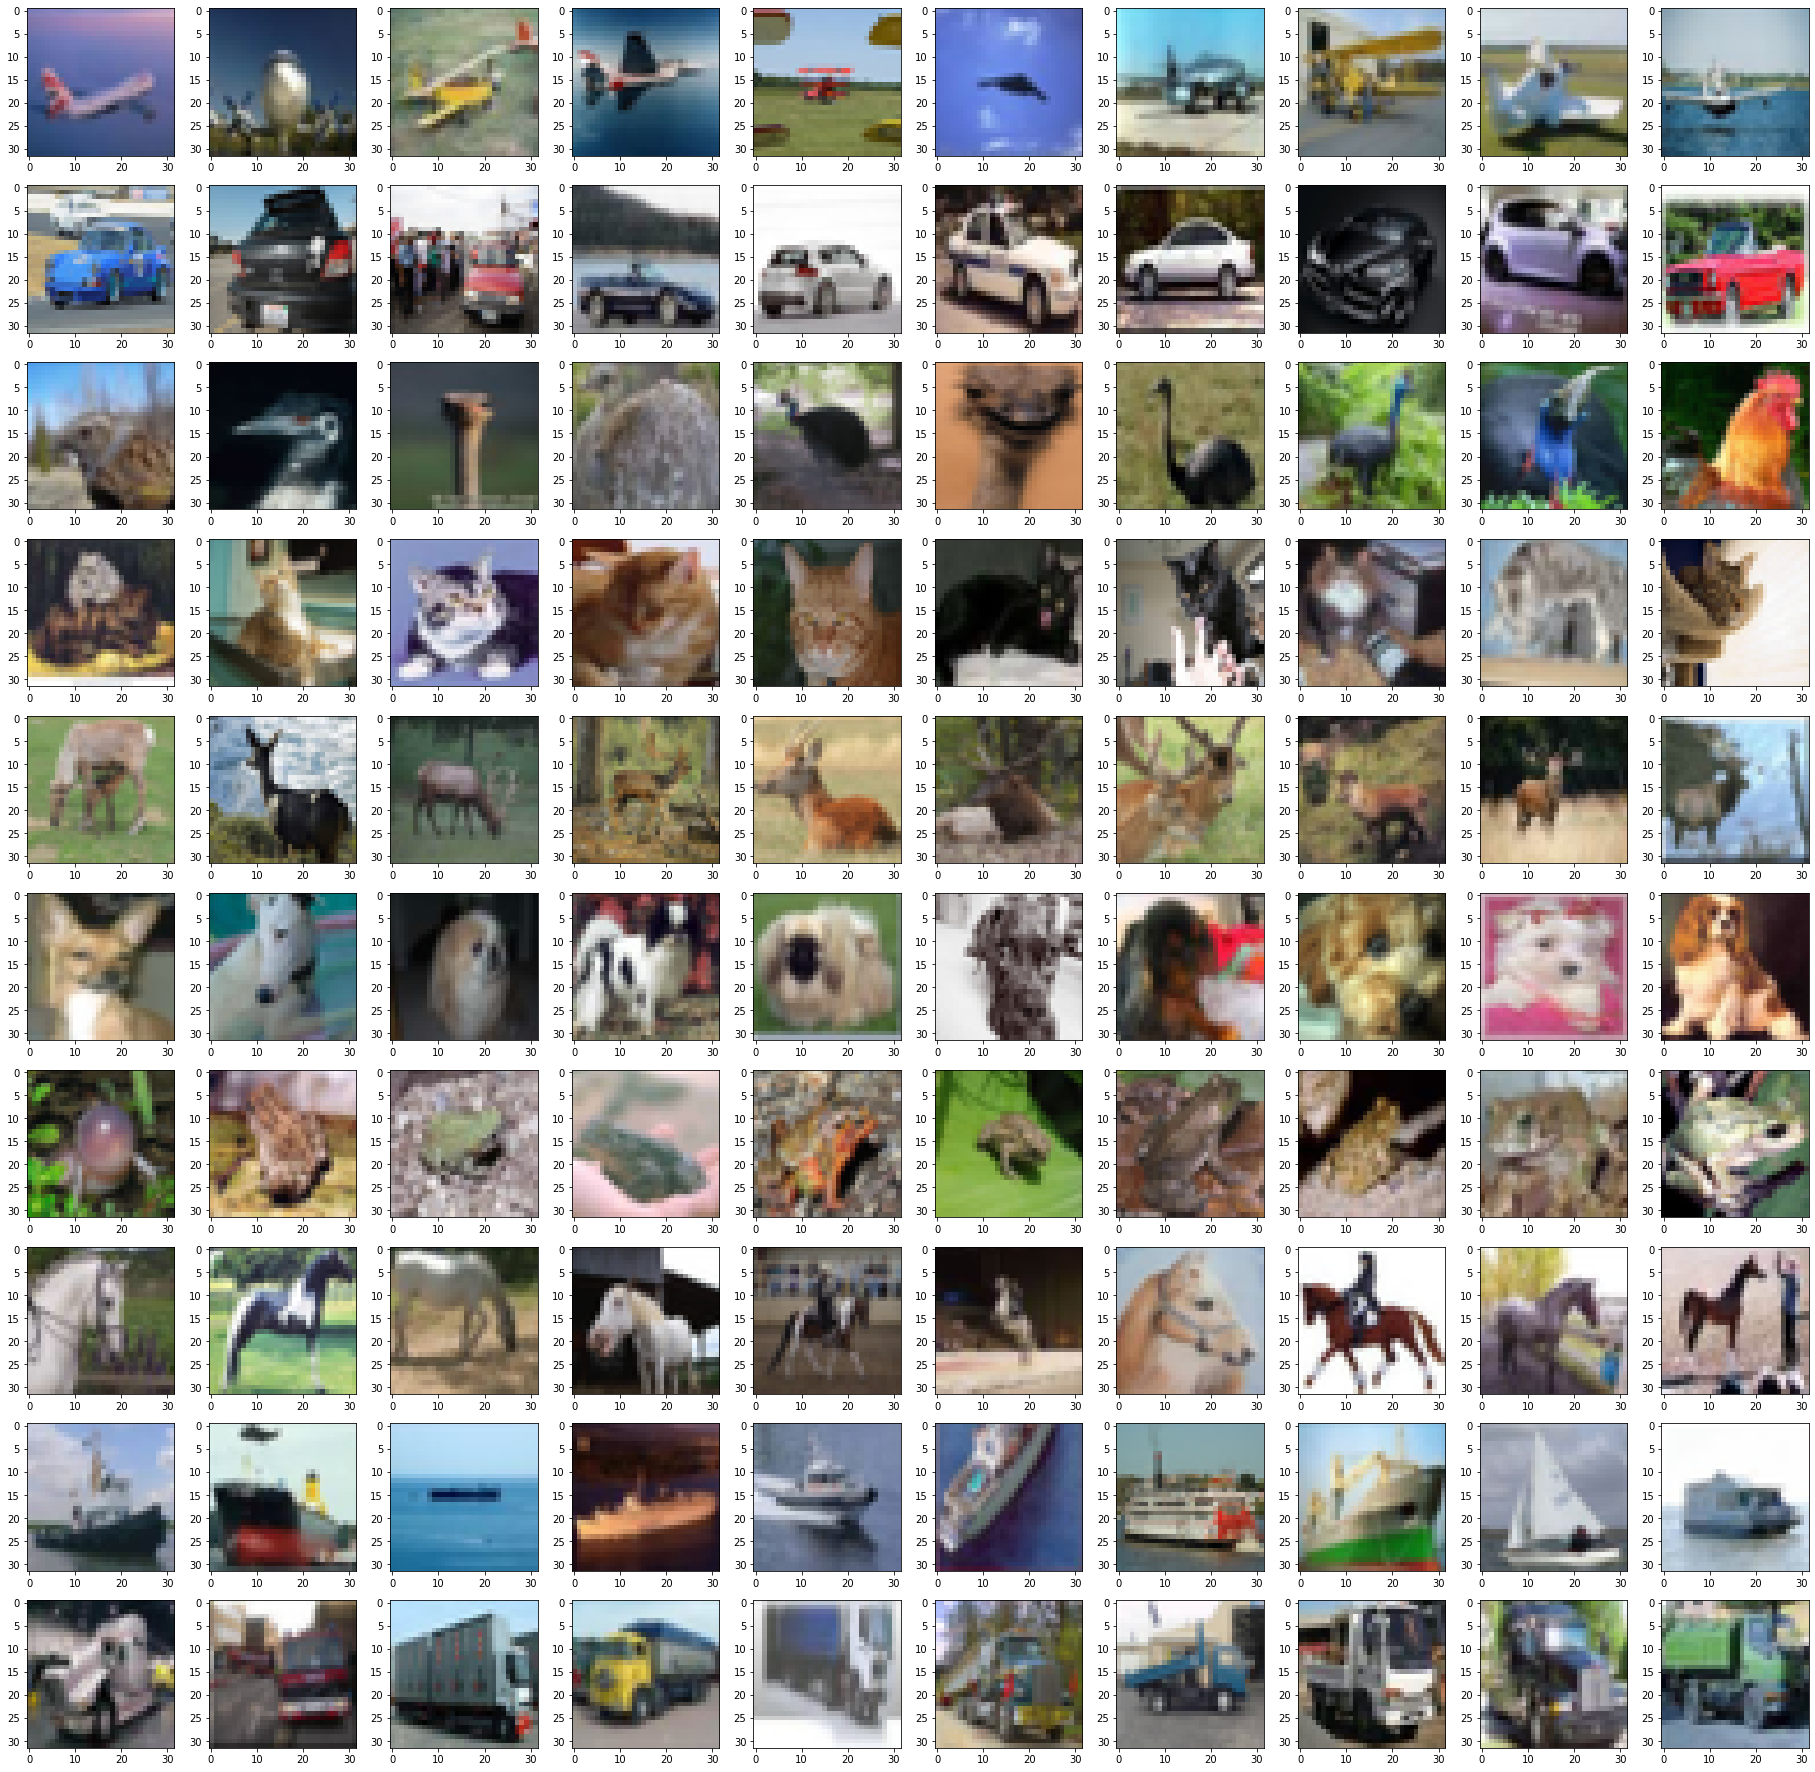

In [42]:
# random data [Dirty dirty don't look at it]
cla = [0] * 10
idx = [[] * 10 for i in range(10)]

while True :
  i = np.random.choice(range(len(Ytrain)))

  if (cla[Ytrain[i]] < 10) :
    idx[Ytrain[i]].append(i)
    cla[Ytrain[i]] += 1
  if sum(cla) == 100 :
    break

idx = np.array(idx)

# Code for plotting

fig, axs = plt.subplots(10,10, figsize=(32,32))
for id, ax in zip(idx.flatten(), axs.flatten()):
  ax.imshow(Xtrain_[id])

Use the convnet from first notebook (Convolutional Neural Network in tensorflow using keras API cell) and train on cifar-10 for **100** epochs. 
* Create a checkpoint to save the best model (see [ModelCheckpoint](https://keras.io/api/callbacks/model_checkpoint/))
* Use the trained model to make predictions on the test data
* Print the **classification_report**
* Print the **confusion_matrix**
* Plot training loss vs. validation loss
* Plot training accuracy vs. validation accuracy 


In [48]:
# CNN definition


def cifar_clf(input_shape=(32,32,3), n_classes=10):
    inx = Input(input_shape)
    x = layers.Conv2D(32, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(inx)
    x = layers.Conv2D(64, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, kernel_size=(3, 3), strides=2, padding='same', activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(n_classes)(x)
    return Model(inx, x)

clf_cifar = cifar_clf()
clf_cifar.summary()

# select loss function and optimizer
loss = losses.CategoricalCrossentropy(from_logits=True)
opt = optimizers.Nadam(learning_rate=1e-2)
clf_cifar.compile(loss=loss, optimizer=opt, metrics=['accuracy'])

# preprocess data: scaling of images, one-hot encoding of labels
def preprocess_tf(x, y):
    return x, tf.one_hot(y, depth=10, axis=-1)

trainset = tf.data.Dataset.from_tensor_slices((Xtrain_, Ytrain)).shuffle(Xtrain_.shape[0]).batch(256).map(preprocess_tf)
valset = tf.data.Dataset.from_tensor_slices((Xval_, Yval)).batch(1000).map(preprocess_tf)

# callback for saving model
MdlCpt = callbacks.ModelCheckpoint('cpt/convnet_cifar', save_best_only=True)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 32)        896       
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 128)               262272    
                                                                 
 dense_7 (Dense)             (None, 10)                1290

In [49]:
# Training
hist = clf_cifar.fit(trainset, valimnist;dation_data=valset, epochs=100, callbacks=[MdlCpt])

Epoch 1/100
40/40 [==============================] - ETA: 0s - loss: 6.1993 - accuracy: 0.1710

40/40 [==============================] - 12s 47ms/step - loss: 6.1993 - accuracy: 0.1710 - val_loss: 2.2736 - val_accuracy: 0.1820
Epoch 2/100
35/40 [=========================>....] - ETA: 0s - loss: 1.9358 - accuracy: 0.2987

40/40 [==============================] - 1s 27ms/step - loss: 1.9285 - accuracy: 0.3016 - val_loss: 2.2163 - val_accuracy: 0.2220
Epoch 3/100
36/40 [==========================>...] - ETA: 0s - loss: 2.9314 - accuracy: 0.2891

40/40 [==============================] - 1s 27ms/step - loss: 2.8887 - accuracy: 0.2842 - val_loss: 2.0693 - val_accuracy: 0.2610
Epoch 4/100
40/40 [==============================] - 0s 9ms/step - loss: 1.9125 - accuracy: 0.3117 - val_loss: 2.0975 - val_accuracy: 0.2890
Epoch 5/100
40/40 [==============================] - 0s 8ms/step - loss: 1.7557 - accuracy: 0.3709 - val_loss: 2.1535 - val_accuracy: 0.2540
Epoch 6/100
40/40 [==============================] - 0s 8ms/step - loss: 1.6543 - accuracy: 0.4054 - val_loss: 2.3280 - val_accuracy: 0.2490
Epoch 7/100
40/40 [==============================] - 0s 9ms/step - loss: 1.6244 - accuracy: 0.4255 - val_loss: 2.3036 - val_accuracy: 0.2980
Epoch 8/100
40/40 [==============================] - 0s 9ms/step - loss: 1.7172 - accuracy: 0.3973 - val_loss: 2.1422 - val_accuracy: 0.3160
Epoch 9/100
40/40 [==============================] - 0s 9ms/step - loss: 1.4692 - accuracy: 0.4828 - val_loss: 2.6398 - val_accuracy: 0.3000
Epoch 10/100
40/40 [====

40/40 [==============================] - 1s 27ms/step - loss: 1.9096 - accuracy: 0.3214 - val_loss: 2.0471 - val_accuracy: 0.2820
Epoch 17/100
40/40 [==============================] - 0s 8ms/step - loss: 3.2163 - accuracy: 0.2400 - val_loss: 2.3263 - val_accuracy: 0.1200
Epoch 18/100
40/40 [==============================] - 0s 9ms/step - loss: 2.3106 - accuracy: 0.1089 - val_loss: 2.3422 - val_accuracy: 0.1040
Epoch 19/100
40/40 [==============================] - 0s 9ms/step - loss: 2.2822 - accuracy: 0.1154 - val_loss: 2.3035 - val_accuracy: 0.1270
Epoch 20/100
40/40 [==============================] - 0s 9ms/step - loss: 2.2508 - accuracy: 0.1420 - val_loss: 2.3038 - val_accuracy: 0.1250
Epoch 21/100
40/40 [==============================] - 0s 8ms/step - loss: 2.2053 - accuracy: 0.1740 - val_loss: 2.1587 - val_accuracy: 0.2040
Epoch 22/100
40/40 [==============================] - 0s 9ms/step - loss: 2.1668 - accuracy: 0.2050 - val_loss: 2.5288 - val_accuracy: 0.1240
Epoch 23/100
40/40

40/40 [==============================] - 1s 35ms/step - loss: 1.8480 - accuracy: 0.3386 - val_loss: 2.0404 - val_accuracy: 0.2900
Epoch 29/100
40/40 [==============================] - 0s 12ms/step - loss: 1.7523 - accuracy: 0.3683 - val_loss: 2.3212 - val_accuracy: 0.2160
Epoch 30/100
40/40 [==============================] - 0s 9ms/step - loss: 1.6928 - accuracy: 0.3988 - val_loss: 2.8569 - val_accuracy: 0.1760
Epoch 31/100
40/40 [==============================] - 0s 8ms/step - loss: 1.8770 - accuracy: 0.3398 - val_loss: 2.2258 - val_accuracy: 0.2440
Epoch 32/100
40/40 [==============================] - 0s 8ms/step - loss: 1.6918 - accuracy: 0.3995 - val_loss: 2.5855 - val_accuracy: 0.2260
Epoch 33/100
40/40 [==============================] - 0s 9ms/step - loss: 1.6313 - accuracy: 0.4227 - val_loss: 2.2729 - val_accuracy: 0.2680
Epoch 34/100
40/40 [==============================] - 0s 8ms/step - loss: 1.5814 - accuracy: 0.4420 - val_loss: 3.4496 - val_accuracy: 0.1380
Epoch 35/100
40/4

In [ ]:
# Code for prediction 

In [ ]:
# Code for classification report and confusion matric

In [ ]:
# Code for training loss vs. val loss

In [ ]:
# Code for training acc vs. val acc

Use your trained convnet as a feature extractor and feed the output of the flatten-layer into a **Support Vector Machine**, which now acts as a classification head (fit an SVC to your training data). Then use the fitted SVC to make predictions on your test data. Print its classification report and the confusion matrix. 

In [ ]:
# Code for the conv feature extractor + SCV classifier

In [ ]:
# Code for making predictions

In [ ]:
# Code for printing classification report and confusion matrix

Implement a NN with the following structure: 
* Input layer -> Conv block 0 -> Conv block 1 -> Conv block 2 -> Conv block 3 -> Dense layer -> Output layer 
* Conv block 0: Conv2D(32, (3,3)) -> Conv2D(32, (3,3))
* Conv block 1: Conv2D(64, (3,3)) -> Conv2D(32, (3,3))
* Conv block 2: Conv2D(128, (3,3)) -> Conv2D(32, (3,3))
* Conv block 3: Conv2D(128, (3,3)) -> Conv2D(32, (3,3))
* Padding is always '**same**', kernel_initializer is '**he_uniform**', and activation function is '**relu**' 
* Dense layer: layers.Flatten() -> layers.Dense(512, activation='relu')
* Output layer: layers.Dense(10) 

* Train this model on the cifar-10 data for 100 epochs and make predictions on the test data
* Create a checkpoint to save the best model (see [ModelCheckpoint](https://keras.io/api/callbacks/model_checkpoint/))
* Print the classification report and confusion matrix
* Plot training loss vs. validation loss
* Plot Training accuracy vs. validation accuracy 
* Did the results improve in comparison to the last model? 

In [ ]:
# Code for model 2 

For the above model, add a batch normalization layer **after each** Conv2D layer. 
* Batch normalization: layers.BatchNormalization()
* You should have two batch normalization layers in each Conv block
* Train this model on the cifar-10 data for 100 epochs and make predictions on the test data
* Create a checkpoint to save the best model (see [ModelCheckpoint](https://keras.io/api/callbacks/model_checkpoint/))
* Print the classification report and confusion matrix
* Plot training loss vs. validation loss
* Plot training accuracy vs. validation accuracy 
* Did the results improve in comparison to the previous two models?


In [ ]:
# Code for model 3

Apply the following changes to the previous model: 
* In Conv block 0: add a Dropout layer with a rate of 0.1 after the second batch normalization layer 
* In Conv block 1: add a Dropout layer with a rate of 0.2 after the second batch normalization layer
* In Conv block 2: add a Dropout layer with a rate of 0.3 after the second batch normalization layer
* In Conv block 3: add a Dropout layer with a rate of 0.4 after the second batch normalization layer
* Add a Dropout layer after the Dense layer with rate 0.5 
* Dropout layer: layers.Dropout(rate)
* Train this model on the cifar-10 data for 100 epochs and make predictions on the test data
* Create a checkpoint to save the best model (see [ModelCheckpoint](https://keras.io/api/callbacks/model_checkpoint/))
* Print the classification report and confusion matrix
* Plot training loss vs. validation loss
* Plot training accuracy vs. validation accuracy 
* Did the results improve in comparison to the previous models?



In [ ]:
# Code for model 4 

Apply [image augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) to the previous model. You can use random translation, random flip, and random rotation. 
* Train this model on the cifar-10 data for 200 epochs and make predictions on the test data
* Create a checkpoint to save the best model (see [ModelCheckpoint](https://keras.io/api/callbacks/model_checkpoint/))
* Print the classification report and confusion matrix
* Plot training loss vs. validation loss
* Plot training accuracy vs. validation accuracy 
* Did the results improve in comparison to the previous models?

In [ ]:
# Code for image augmentation + the rest of the tasks mentioned above

 Create 3D scatter plots (per class) of the first 3 principal components on:
 * Raw images 
 * Simple Convnet features
 * Features of the best performing model 

 Describe your observation from the three plots


In [ ]:
# Code for the three different 3D scatter plots 